In [230]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [231]:
year = 20
donors_csv = f"./output/donors_state{year}_pred_lastname.csv"

In [232]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [233]:
len(donors)

3588936

In [234]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

52.08035503339197


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [235]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind
373,p00053429381,"MANTENA, RAMALINGA",ramalinga mantena,Integra Connect,NaN,H3900,F,SELF-EMPLOYED,INTEGRA CONNECT LLC,JUPITER,FL,1241200.0,45,27582.222222,10000.0,mantena,ind
377,U0000004388A,"MANTENA, PADMAJA",padmaja mantena,Integra Connect,NaN,H3900,F,HOMEMAKER,HOMEMAKER,JUPITER,FL,1235200.0,47,26280.851064,10000.0,mantena,ind
492,h3003465387,"AYYADURAI, SHIVA",shiva ayyadurai,[Candidate Contribution],NaN,Z9000,U,CHAIRMAN & CEO,"CYTOSOLVE, INC.",BELMONT,MA,1044900.0,21,49757.142857,2000.0,ayyadurai,ind
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind
529,h3001220400,"MULYE, NIRMAL",nirmal mulye,Nostrum Pharmaceuticals,NaN,H4300,M,CHAIRMAN,NOSTRUM PHARMACEUTICALS,MIAMI,FL,986499.0,69,14297.086957,7068.0,mulye,ind
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind


In [236]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
80911468.0
0.6740264386081463 % of donated amount is from diaspora


In [237]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

3588936
21028
0.5859118134176815 % of donors are from diaspora


In [238]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

3.0
2.0


In [239]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

432.0
575.0


In [240]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3344.7790545721627
3847.796652082937


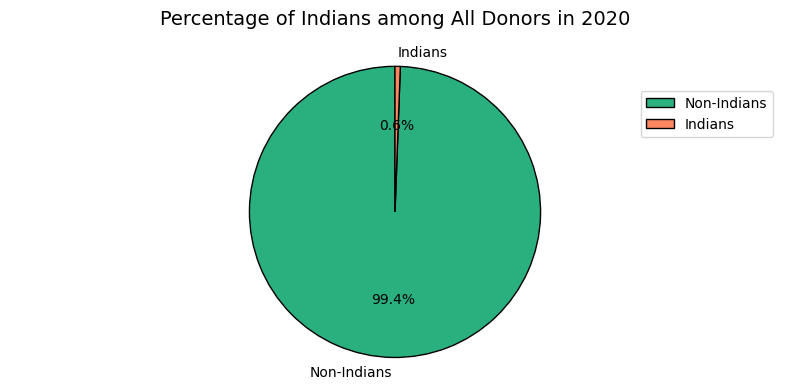

In [241]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [242]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Unknown                  680118
Party                    457704
Ideology/Single Issue    351066
Health                   306837
Finance                  232336
Tech                     122934
Labor                    106811
Law                       79766
Transportation            75121
Construction              66659
Energy                    58773
Agribusiness              43488
Manufacturing             31758
Defense                   26274
Name: count, dtype: int64

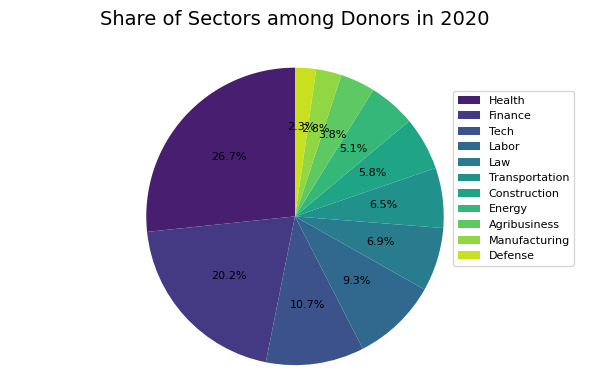

In [243]:
employ_counts = donors['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]

plt.figure(figsize=(6, 4))

wedges, _, _ = plt.pie(
    employ_counts,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)

plt.title(f'Share of Sectors among Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(wedges, employ_counts.index, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=8)
plt.tight_layout()
plt.show()

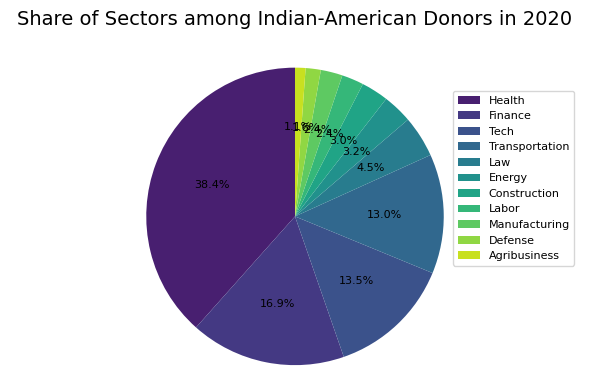

In [244]:
employ_counts_indian = donors[donors['ethnic'] == 'ind']['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]

plt.figure(figsize=(6, 4))

wedges, _, _ = plt.pie(
    employ_counts_indian,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts_indian)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)

plt.title(f'Share of Sectors among Indian-American Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(wedges, employ_counts_indian.index, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=8)
plt.tight_layout()
plt.show()

In [245]:
state_stats = (
    donors.groupby(["state", "sector"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,sector,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,CA,Unknown,13371.801337,250.0,1.390132e+09,103960,2166.798680,500.0,1969620.0,909
1,NY,Party,37416.322204,1000.0,1.329065e+09,35521,3441.301746,1000.0,1379962.0,401
2,CA,Party,9238.886828,1000.0,7.317845e+08,79207,4161.753560,1000.0,3799681.0,913
3,NY,Finance,13862.748378,1000.0,3.012514e+08,21731,13464.554264,1000.0,3473855.0,258
4,CA,Finance,10300.775519,558.0,3.009269e+08,29214,33976.804636,1000.0,10260995.0,302
5,CA,Tech,6862.785785,500.0,2.205425e+08,32136,3008.189904,533.5,1251407.0,416
6,FL,Finance,10085.211906,500.0,1.431596e+08,14195,1875.745098,500.0,95663.0,51
7,TX,Party,4364.553908,1000.0,1.430613e+08,32778,4166.876033,1100.0,1512576.0,363
8,CA,Ideology/Single Issue,2101.807827,320.0,1.410334e+08,67101,2040.819018,391.5,665307.0,326
9,CA,Health,2804.066474,352.0,1.233845e+08,44002,6621.595782,600.0,3767688.0,569


In [246]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [247]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [248]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [249]:
most_sector = (
    gdf_merged[~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        total_donations=("total_donations", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("total_donations", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector = gpd.GeoDataFrame(most_sector, geometry='geometry', crs=gdf_merged.crs)

most_sector_indian = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        total_donations_indian=("total_donations_indian", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("total_donations_indian", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector_indian = gpd.GeoDataFrame(most_sector_indian, geometry='geometry', crs=gdf_merged.crs)

In [250]:
most_sector2 = (
    gdf_merged[~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        donor_count=("donor_count", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("donor_count", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector2 = gpd.GeoDataFrame(most_sector2, geometry='geometry', crs=gdf_merged.crs)

most_sector2_indian = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        donor_count_indian=("donor_count_indian", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("donor_count_indian", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector2_indian = gpd.GeoDataFrame(most_sector2_indian, geometry='geometry', crs=gdf_merged.crs)

In [251]:
most_sector2_indian.iloc[0]

state                                                                CA
sector                                                           Health
donor_count_indian                                                  569
geometry              POLYGON ((-114.64222164595688 35.0531061874735...
Name: 38, dtype: object

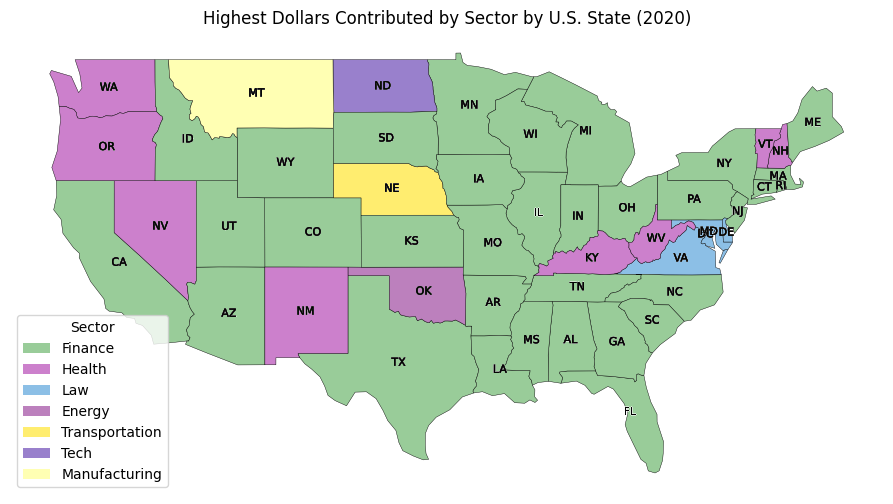

In [256]:
color_map = dict(zip(most_sector_indian["sector"], plt.cm.Set3(np.linspace(0, 1, len(most_sector_indian["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])

fig, ax = plt.subplots(figsize=(12, 6))
most_sector.plot(
    column="sector",
    color=[color_map[s] for s in most_sector['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Dollars Contributed by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

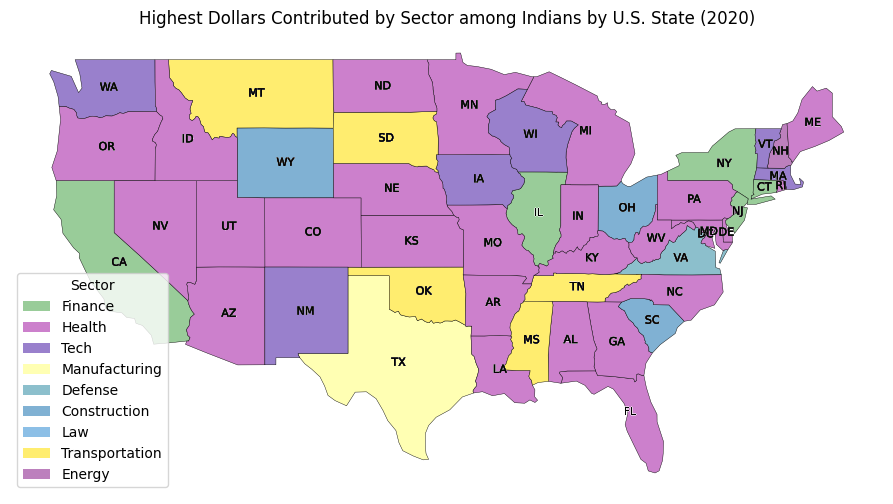

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))
most_sector_indian.plot(
    column="sector",
    color=[color_map[s] for s in most_sector_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Dollars Contributed by Sector among Indians by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

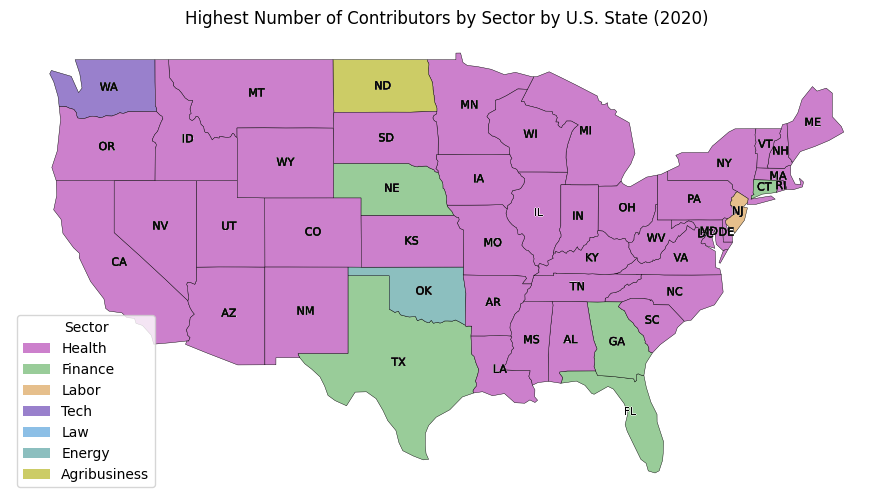

In [265]:
color_map = dict(zip(most_sector2_indian["sector"], plt.cm.Set3(np.linspace(0, 1, len(most_sector2_indian["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])
color_map["Labor"] = np.array([0.9, 0.75, 0.55, 1])
color_map["Energy"] = np.array([0.55, 0.75, 0.75, 1])

fig, ax = plt.subplots(figsize=(12, 6))
most_sector2.plot(
    column="sector",
    color=[color_map[s] for s in most_sector2['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector2["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Contributors by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

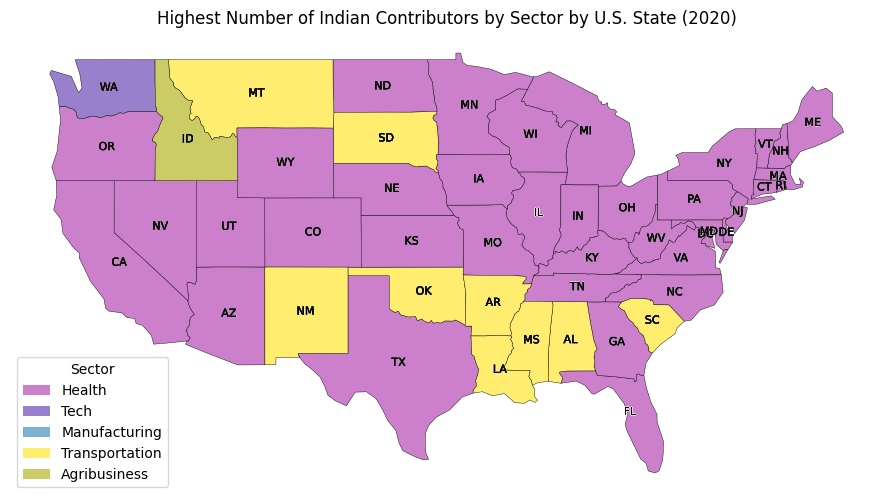

In [266]:
fig, ax = plt.subplots(figsize=(12, 6))
most_sector2_indian.plot(
    column="sector",
    color=[color_map[s] for s in most_sector2_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector2_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Indian Contributors by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [279]:
temp = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby("state", group_keys=False)  # Keep original index
    .apply(lambda g: g.nlargest(3, "total_donations_indian")) 
    .sort_values("total_donations_indian", ascending=False)
    .reset_index()
)
temp.drop(columns=["geometry"])[temp["state"] == "CA"]

,index,iso_3166_2,name,state,sector,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,86,US-CA,California,CA,Finance,10300.775519,558.0,300926856.0,29214,33976.804636,1000.0,10260995.0,302,2020,California,CA,856180,39521958,2.16634
2,89,US-CA,California,CA,Health,2804.066474,352.0,123384533.0,44002,6621.595782,600.0,3767688.0,569,2020,California,CA,856180,39521958,2.16634
6,87,US-CA,California,CA,Tech,6862.785785,500.0,220542484.0,32136,3008.189904,533.5,1251407.0,416,2020,California,CA,856180,39521958,2.16634


In [267]:
donors[(donors["state"] == "CA") & (donors["sector"] == "Finance") & (donors["ethnic"] == "ind")].sort_values(by="total_donated", ascending=False).head()

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic,sector
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind,Finance
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind,Finance
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind,Finance
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind,Finance
765,r0014803404,"ALWAN, KHALID",khalid alwan,Investor,NaN,F7000,M,SELF EMPLOYED,SELF-EMPLOYED,BEVERLY HILLS,CA,721838.0,125,5774.704000,3486.0,alwan,ind,Finance


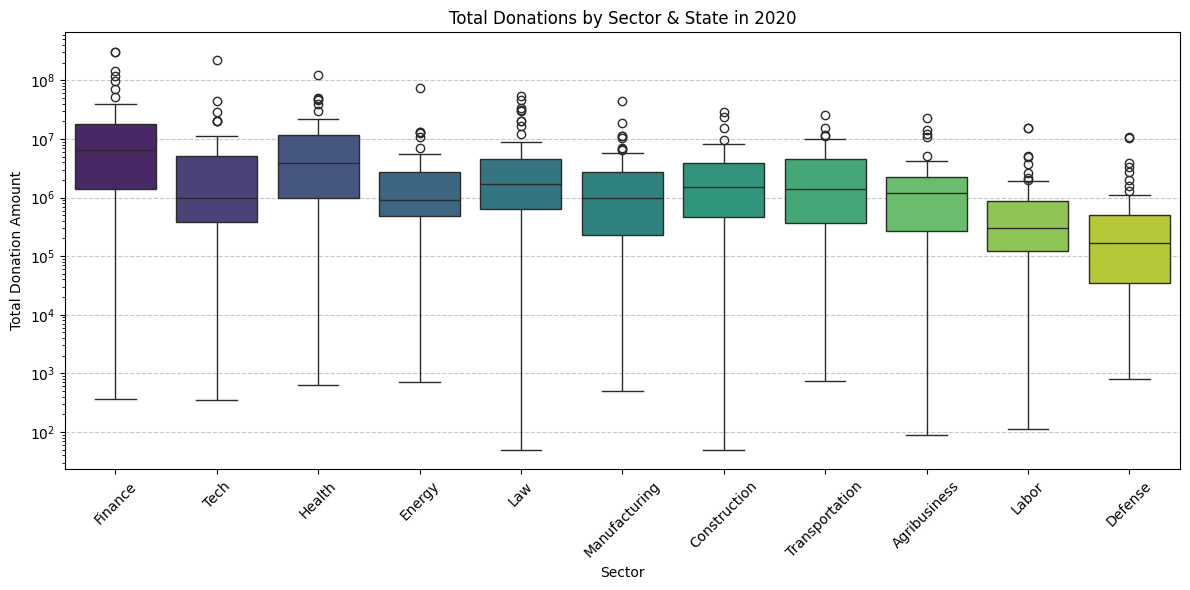

In [276]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=state_stats[~state_stats["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])], x="sector", y="total_donations", palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Total Donations by Sector & State in 20{year}")
plt.xlabel("Sector")
plt.ylabel("Total Donation Amount")
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

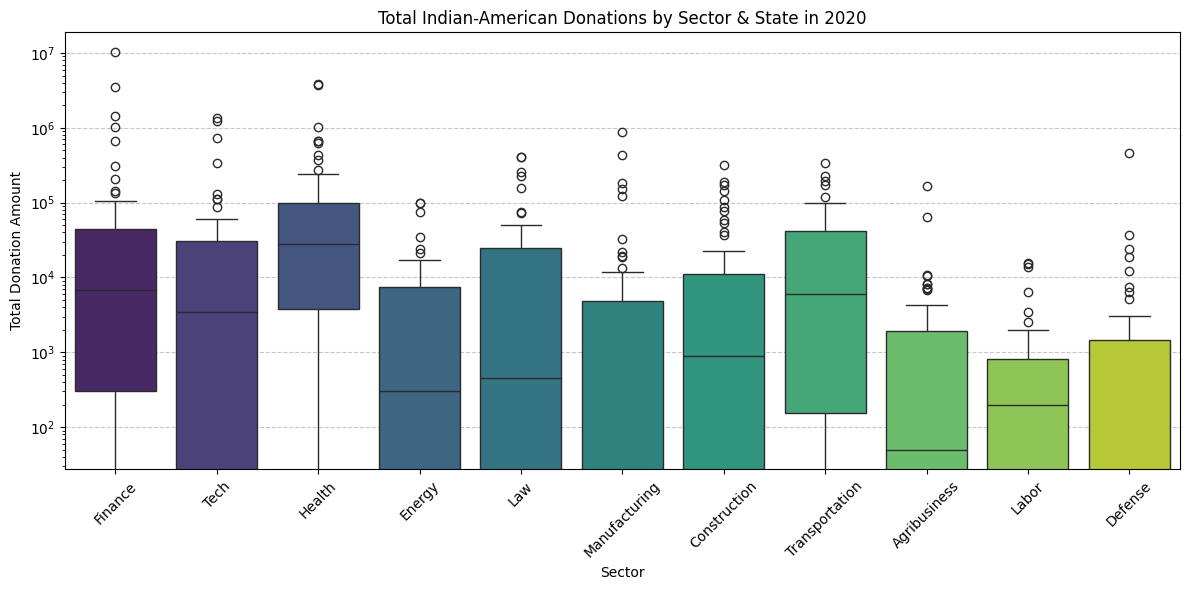

In [277]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=state_stats[~state_stats["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])], x="sector", y="total_donations_indian", palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Total Indian-American Donations by Sector & State in 20{year}")
plt.xlabel("Sector")
plt.ylabel("Total Donation Amount")
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()